# Téma 1: Úvod do problematiky, Markovské procesy

In [2]:
import numpy as np
import matplotlib.pylab as plt

np.set_printoptions(precision=3)

> **Definice**
>
> Časová řada je soubor pozorování (označených např. $x_t$) získaných v konkrétních časových okamžicích $t$.

> *Maličko přesněji: Buď $(\Omega, \mathcal{F}, P)$ pravděpodobnostní prostor a $T$ množina indexů interpretovaných jako čas. Časovou řadou nazýváme množinu $\{X_t, t\in T\}$, kde $X_t$ jsou náhodné veličiny z $(\Omega, \mathcal{F}, P)$.*

Je-li $t\in \mathbb{Z}$, mluvíme o časové řadě (náhodném procesu) s diskrétním časem. Naopak, je-li $t\in\mathbb{R}$, jde o řadu (proces) se spojitým časem. Samozřejmě se můžeme omezit jen na nezáporné indexy apod.

Pozorování $x_t$ mohou být rovněž z množiny reálných čísel, přirozených čísel atd. V našem předmětu se budeme prakticky výhradně zabývat reálnými časovými řadami s diskrétním časem.

## Příklady časových řad
Časové řady, resp. data měřená v pevných či proměnných časových okamžicích, se vyskytují v naprosté většině odvětví. Níže si představíme pár příkladů.

### Časové řady v ekonomii, financích a marketingu
Analýza časových řad byla odjakživa velmi populární v ekonomii, financích a marketingu, neboť umožňovala odhadovat budoucí vývoj na základě minulosti. Sledovat tak lze celou řadu ukazatelů jako cenové indexy (viz index cen mouky níže), ceny akcií, směnné kurzy (czk-eur níže), ceny komodit (viz cena ropy níže), nezaměstnanost atd.

![BWPI](img/l1-beveridge-wheat-price-index-150.png)
![OP](img/l1-oil-prices-in-constant-1997-doll.png)
![EXCH](img/l1-euro-foreign-exchange-reference.png)

### Fyzikální časové řady
Časové řady ve fyzice, geofyzice, meteorologii atd. Vznikají jako posloupnost měření určitého fenoménu za účelem jeho další analýzy.
![SSPOT](img/l1-yearly-mean-total-sunspot-number.png)
![TEMP](img/l1-longterm-monthly-temperature-s.png)

### Demografické časové řady
Tyto časové řady ukazují vývoj populace.

![POP](img/l1-total-population-both-sexes-com.png)

### Časové řady v průmyslu, IT, automatizacích atd.

Zde mají časové řady velký význam pro řízení systémů a procesů, ať už ve výrobě, telekomunikačních sítích či jinde.
![BS](img/l1-global-broadband-performance.png)
(Aggregated broadband speed data from around the world, based on results from speedtest.net and pingtest.net)

## Cíle analýzy časových řad
1. **Popis pozorovaného jevu** - velmi často je cílem pouze vysledovat vlastnosti pozorovaného systému či procesu, např. rozsah hodnot, periodicita a sezónnost, krátkodobý a dlouhodobý vývoj, přítomnost odlehlých a extrémních hodnot, analýza závislostí mezi několika časovými řadami, resp. měřenými veličinami atd. Analýza je v první fázi často realizována pouhým vykreslením grafu vývoje časové řady a subjektivní vizuální analýzou.

2. **Predikce budoucího vývoje popř. interpolace vývoje minulého**. Tento cíl je potom velmi často spjat rovněž s řízením.

3. **Řízení** - je-li potřeba řídit nějaký proces, např. ve výrobě, je nezbytné vycházet z měřených dat, která tento proces determinují.

## Vlastnosti časových řad
### Variabilita vývoje
1. **Trend** - obecně definovaný jako *dlouhodobý vývoj střední hodnoty*. Tato definice je ovšem poměrně vágní, protože v dlouhém běhu může časová řada vykazovat *cyklické změny*, které v kratším (avšak stále relativně dlouhém) časovém úseku připisujeme trendu. To se typicky týká klimatických podmínek.
2. [**Sezónnost**](https://en.wikipedia.org/wiki/Seasonality) - periodicky se opakující, poměrně pravidelný a předpověditelný (očekávatelný) vývoj časové řady. Typické jsou například vývoje teploty v průběhu roku, počet zákazníků v pneuservisech, počet zaměstnanců v zemědělství, počet zákazníků v horských centrech apod. Sezónnost můžeme celkem dobře analyzovat v příslušném [grafu sezónnosti](https://en.wikipedia.org/wiki/Seasonal_subseries_plot), či lépe v řadě box plotů, oba vyžadují znalost periody. Tu můžeme zjistit pomocí *autokorelační funkce* (ACF). Pro analýzu sezónnosti je ale vždy potřeba nejprve odstranit *trend*.
3. **Cyklické změny** - fluktuace, které zpravidla nemají pevnou periodu, např. ekonomické cykly.
4. **Další nepravidelné fluktuace**

![seasonal.png](img/seasonal.png)
_Graf sezónnosti - jednotlivé sezóny versus realizace. Zdroj: www.wikipedia.org._

Časovou řadu lze často rozložit na jednotlivé uvedené složky, přičemž cyklické změny a nepravidelné fluktuace se zpravidla sloučí do jedné. Používají se především dva modely:
   - **aditivní**: $Y_t = T_t + S_t + E_t$,
   - **multiplikativní**: $Y_t = T_t \cdot S_t \cdot E_t$,
   
kde $Y_t$ je pozorovaná veličina v čase $t$, $T_t$ je hodnota trendu, $S_t$ je sezónní složka a $E_T$ nevysvětlená složka. V aditivních modelech obecně platí, že amplituda sezónních složek je přibližně stejná, zatímco v multiplikativních se s rostoucím trendem zvyšuje i sezónní amplituda (a naopak). Jedním z možných kritérií, jak vybrat vhodný model, je minimalizovat součet čtverců hodnot autokorelační funkce reziduí $E_t$, neboť ACF nám říká, jaká míra korelace v $E_t$ zbyla.

Od pozorované veličiny lze samozřejmě pro různé aplikace odečítat složku trendu nebo sezónnosti.

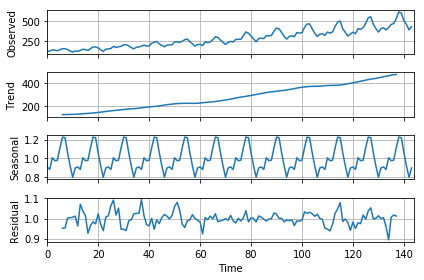

In [14]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('../zdrojaky/international-airline-passengers.csv', header=0)
series = df['Passengers']

result = seasonal_decompose(series.values, freq=12, model='multiplicative')
result.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import acf
resid_acf = acf(result.resid, nlags=10, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

Suma kvadrátů reziduí ACF: 2.5529216279884563


**K zamyšlení:**
- jak udělat z multiplikativní řady aditivní?

## Časová řada jako náhodný proces

Zaveďme si, s ohledem na znalosti z teorie pravděpodobnosti, definici náhodného procesu následujícím (neskutečně vágním ;-) způsobem:

> Náhodný proces je posloupnost náhodných veličin $X_t$, kde $t$ je z vhodné množiny indexů.

Z hlediska indexové množiny dělíme náhodné procesy na procesy *diskrétní* či *spojité*, alternativně s diskrétním či spojitým časem. Podle toho je množina indexů buď z oboru celých či přirozených čísel, anebo (celou nebo nezápornou) množinou přirozených čísel. Kdybychom toužili si situaci zkomplikovat, můžeme ovšem uvažovat i jiné množiny.

Z hlediska oboru hodnot $X_t$, někdy též stavového prostoru, mohou být procesy rovněž spojité nebo diskrétní, případně jiné. Navíc mohou být vícerozměrné, např. poloha ve 2D prostoru je dvourozměrná.

Náhodná veličina $X_t$ nabývá pozorované hodnoty $x_t$, tedy $X_t = x_t$. Toto notační pravidlo ale nebudeme striktně dodržovat, ačkoliv je to matematicky ne zrovna přijatelné, v inženýrské praxi se mezi náhodnou veličinou a její realizací rozlišuje poměrně zřídka. 

### Momenty
Jednou z možností, jak popisovat časovou řadu, by bylo uvažovat sdruženou distribuci veličin $X_{t_1},\ldots,X_{t_n}$ pro posloupnost indexů $t_1, \ldots, t_n$. To je ovšem v praxi příliš komplikované a namísto toho jsou uvažovány pouze momenty:
- střední hodnota $\mu_t = \mathbb{E}[X_t]$
- variance $\sigma_t^2 = \operatorname{var} X_t$
- autokovariance $\gamma(t_1, t_2) = \operatorname{cov}(X_{t_1}, X_{t_2}) = \mathbb{E}[(X_{t_1} - \mu_{t_1})(X_{t_2} - \mu_{t_2})]$.

Vyšší momenty - centrální i obecné - je rovněž možné uvažovat, avšak v praxi je to řídké.

### Stacionarita
> Říkáme, že časová řada je striktně stacionární, pokud sdružená distribuce $X_{t_1},\ldots, X_{t_n}$ je stejná, jako sdružená distribuce $X_{t_1+\tau},\ldots, X_{t_n+\tau}$ pro všechna $t_1, \ldots, t_n, \tau$.

Definice tedy říká, že posun o libovolný čas $\tau$ nemá vliv na sdruženou distribuci a ta tedy závisí jen na časech $t_1, t_2, \ldots, t_n$ pro libovolná $n$. 
- Budeme-li tedy uvažovat $n=1$, potom striktní stacionarita znamená, že distribuce $X_{t}$ je stejná pro všechna $t$ a rovněž momenty $\mu = \mu_t$ a $\sigma^2 = \sigma_t^2$ jsou v čase konstantní.

- Uvažujeme-li $n=2$, distribuce $[X_{t_1}, X_{t_2}]$ závisí na zpoždění, též posunu (angl. _lag_) $t_2 - t_1$.

S pojmem zpoždění je spjata rovněž autokovariance, kde můžeme uvažovat
$$
\gamma(\tau) = \operatorname{cov}(x_t, x_{t+\tau})
$$

**Příklad:**
 Může se zdát zvláštní, že nějaký proces má mít stejná rozdělení $X_t$ pro všechna $t$. Ve skutečnosti existuje celá řada procesů, které - často bez ohledu na počáteční podmínky - konvergují k limitní distribuci (*equilibrium, stationary distribution*), kde je přesně tento stav splněn.

> Říkáme, že časová řada je slabě stacionární, pokud je invariantní vůči posunům v čase pouze v rámci momentů rozdělení do druhého řádu, tj.
> 
$$\begin{aligned}
\mathbb{E}[X_t] &= \mu,\\
\operatorname{cov}(X_t, X_{t+\tau}) &= \gamma(\tau).
\end{aligned}
$$

Pro většinu budoucí práce v předmětu si vystačíme se slabou stacionaritou.

**K zamyšlení**
- jak se z autokovariance stane variance?
- vyplývá ze striktní stacionarity slabá? Jsou nějaké omezující podmínky (nápověda: Cauchyova distribuce)

## Příklady náhodných procesů

### Bílý šum
[Bílý šum](https://en.wikipedia.org/wiki/White_noise) je náhodný proces $\{X_t\}$, kde

$$
\begin{aligned}
\mathbb{E}[X_t] &= 0, \\
\operatorname{var}(X_t) &= \sigma^2 < \infty,\\
\operatorname{cov}(X_t, X_{t+\tau}) = \gamma(\tau) &= 0.
\end{aligned}
$$

Jde tedy proces, jehož rozdělení má nulovou střední hodnotu (někdy se uvádí pouze *konstantní*), konstantní konečnou varianci a nezávislost mezi $X_t$ a $X_{t+\tau}$ pro $\tau > 0$. Jednotlivá $X_t$ jsou tedy nezávislá a identicky rozdělená (*iid, independent and identically distributed*).

Speciálním případem je potom normální (gaussovský) bílý šum, kde $X_t \sim \mathcal{N}(0, \sigma^2)$.

Bílý šum má celou řadu praktických využití, např. ve zvukové syntéze, generátorech náhodných čísel aj.

**K zamyšlení**
- jak vypadá hustota normálního bílého šumu pro $n$ složek?
- jak je to se stacionaritou bílého šumu?


### Náhodná procházka
Uvažujme diskrétní bílý šum $Z_t \sim \mathcal{L}(0, \sigma^2)$. Proces $\{X_t\}$ nazýváme [náhodnou procházkou](https://en.wikipedia.org/wiki/Random_walk), pokud
$$
\begin{aligned}
X_0 &= 0,\\
X_t &= X_{t-1} + Z_t,
\end{aligned}
$$

a tedy $X_t = \sum_{i=1}^t Z_t$.

Vidíme, že $\mathbb{E}[X_t] = 0$ a $\operatorname{var}(X_t) = t\sigma^2$.

Náhodná procházka je oblíbeným modelem pro modelování cen akcií, ve fyzice pro popis Brownova pohybu, v computer science pro odhad velikosti webu atd.

**K zamyšlení**
- je náhodná procházka stacionární?
- jsou přírůstky v náhodné procházce stacionární?


### Další procesy
Wienerův proces, poissonovský proces, markovský proces, MA, ARMA, AR... O některých z nich později.

## Markovský proces

**OBRÁZEK OBRÁZEK OBRÁZEK**

> **Stavem** markovského procesu $\{X_t\}$ v čase $t$ nazýváme hodnotu $X_t$.

> **Stavovým prostorem** $S$ markovského procesu je množina hodnot $X_t$.

Tato množina může být libovolná, spočetná i nespočetná, konečná atd.

> **Trajektorií** markovského procesu nazýváme posloupnost hodnot $X_1, X_2, \ldots$.

My se budeme zabývat specificky [**Markovskými řetězci**](https://en.wikipedia.org/wiki/Markov_chain), což jsou Markovské procesy s diskrétním časem a spojitým stavovým prostorem. Tato definice sice není [jednotná](https://en.wikipedia.org/wiki/Markov_chain), někdy je diskrétnost připisována stavovému prostoru, nicméně v předmětu se budeme zabývat výhradně časově diskrétními procesy. Zavedeme si pojem [**Markovské vlastnosti**](https://en.wikipedia.org/wiki/Markov_chain#Markov_property) jež nám výrazně zjednoduší další práci.

>  **Markovská vlastnost**

>$$
\mathbb{P}(X_{t+1} = x|X_t=x_t, X_{t-1}=x_{t-1}, \ldots, X_1=x_1) = \mathbb{P}(X_{t+1} = x|X_t=x_t)
$$

>pokud $\mathbb{P}(X_t=x_t, X_{t-1}=x_{t-1}, \ldots, X_1=x_1)>0$.

Markovský řetězec je takový markovský proces, pro který platí markovská vlastnost pro všechny časové indexy $t$ a pro všechny hodnoty statového prostoru. Existují i **markovské procesy n-tého řádu**, v nichž pro konečné $n$ platí

$$
\mathbb{P}(X_{t+1} = x|X_t=x_t, X_{t-1}=x_{t-1}, \ldots, X_1=x_1) = \mathbb{P}(X_{t+1} = x|X_t=x_t, X_{t-n}=x_{t-n}),
$$

opět za podmínky $\mathbb{P}(X_t=x_t, X_{t-1}=x_{t-1}, \ldots, X_1=x_1)>0$. Tyto procesy jsou takzvaně s pamětí, vyskytují se v řadě aplikací, ovšem počítání s nimi je poněkud složitější. Typickým příkladem, kde lze užít markovský proces n-tého řádu, je generování náhodného textu, např. na způsob [SciGenu](https://pdos.csail.mit.edu/archive/scigen/), ten ovšem markovský proces nevyužívá.

Nás spíš bude zajímat **homogenní (též stacionární) markovský řetězec**, v němž je přechodová pravděpodobnost nezávislá na čase.

> Markovský řetězec $\{X_t\}$ je homogenní, pokud pro všechna $t$ platí

>$$
\mathbb{P}(X_{t+1} = x|X_t=x_t) = \mathbb{P}(X_{t} = x|X_{t-1}=x_{t-1}).
$$

### Přechodová matice, přechodový graf

![Přechodový graf](img/transition-graph.jpg)
![Přechodová matice](img/transmatrix.jpg)

V přechodové matici:
- řádky označují aktuální stav, tedy ODKUD, $X_t$,
- sloupce označují stav budoucí, tedy KAM, $X_{t+1}$

Je patrné, že matice $P = (p_{ij})$ jde $p_{ij} = \mathbb{P}(X_{t+1}=j|X_t=i)$, tedy pravděpodobnost přechodu ze stavu $X_t=i$ do stavu $X_{t+1}=j$.

**K zamyšlení**
- Obsahuje matice $P$ všechny stavy?
- Jaký je rozměr matice, pokud máme stavový prostor o dimenzi $N$?
- Co můžeme říci o $\sum_{i=1}^N p_{ij}$?
- A co o $\sum_{j=1}^N p_{ij}$?



### Pravděpodobnost přechodu v $t$ krocích

Uvažujme markovský řetězec $\{X_0, X_1, \ldots\}$ se stavovým prostorem $S=\{1,2,\ldots,N\}$. K němu budiž dána přechodová matice $P$ s prvky - jak už víme

$$
p_{ij} = (P)_{ij} = \mathbb{P}(X_{t+1}=j|X_t=i) \qquad \text{pro libovolné $t$}.
$$

Řešme otázku, jaká je pravděpodobnost, že přejdeme ze stavu $i$ do stavu $j$ ve dvou krocích, tedy

$$
\mathbb{P}(X_2=j|X_0=i).
$$

Máme tedy uvažovat řadu jevů $i\to k \to j$, kde $k$ je prvek na cestě z $i$ do $j$. Připomeňme, že jednotlivé cesty jsou *nezávislé*, pravděpodobnosti tedy budeme *sčítat*, zatímco pravděpodobnosti v rámci každé jednotlivé cesty jsou *závislé, podmíněné* a budou se tedy *násobit*:

$$
\begin{aligned}
\mathbb{P}(X_2=j|X_0=i) 
&= \sum_{k=1}^{N} \mathbb{P}(X_2=j|X_1=k, X_0=i) \mathbb{P}(X_1=k|X_0=i) \\
&= \sum_{k=1}^{N} \mathbb{P}(X_2=j|X_1=k) \mathbb{P}(X_1=k|X_0=i) \qquad\text{(proč?)} \\
&= \sum_{k=1}^{N} p_{kj} p_{ik} \\
&= \sum_{k=1}^{N} p_{ik} p_{kj} \\
&= (P^2)_{ij} \qquad\quad\text{(proč?)}
\end{aligned}
$$

> **Věta**
> Nechť $\{X_0, X_1, \ldots\}$ je markovský řetězec s přechodovou maticí $P$ rozměru $N\times N$. Potom $t$-krokové přechodové pravděpodobnosti jsou dány prvky matice $P^t$, tedy
>
> $$
\mathbb{P}(X_t=j|X_0=i) = (P^t)_{ij},
$$
>
> obecněji
>
>$$
\mathbb{P}(X_{\tau+t}|X_\tau) = (P^t)_{ij}
$$
>
>pro libovolné $\tau$.


**K zamyšlení**
- zkuste si celou situaci odvodit s pomocí grafu

### Distribuce $X_t$

Uvažujme opět markovský řetězec $\{X_0, X_1, \ldots\}$ se stavovým prostorem $S=\{1,\ldots, N\}$. Jelikož $X_t$ je **náhodná veličina**, musí mít i odpovídající **rozdělení pravděpodobnosti**, tedy **distribuci**. Jelikož možných stavů je $N$, bude takové rozdělení popsáno vektorem o rozměru $N$:

$$
\pi =
\begin{bmatrix}
\pi_1 \\ \pi_2 \\ \vdots \\ \pi_N
\end{bmatrix}
=
\begin{bmatrix}
\mathbb{P}(X_t=1) \\ \mathbb{P}(X_t=2) \\ \vdots \\ \mathbb{P}(X_t=N)
\end{bmatrix}.
$$

My zde vynecháme časový index, nicméně je možné jej psát. Můžeme tak například psát, že $X_0 \sim \pi^{\intercal}$, tedy že počáteční distribuce, $X_0$, je $\pi$. Určeme nyní distribuci $X_1$:

$$
\begin{aligned}
\mathbb{P}(X_1 = j)
&= \sum_{i=1}^N \mathbb{P}(X_1=j|X_0=i) \mathbb{P}(X_0=i) \\
&= \sum_{i=1}^N p_{ij} \pi_i \\
&= \sum_{i=1}^N \pi_i p_{ij} \\
&= (\pi^T P)_j.
\end{aligned}
$$

Co z toho plyne?

$$
\begin{aligned}
X_0 &\sim \pi^\intercal \\
X_1 &\sim \pi^\intercal P \\
X_2 &\sim \pi^\intercal P \cdot P \\
&\vdots \\
X_t &\sim \pi^\intercal P^t.
\end{aligned}
$$

> Věta:
> Nechť $\{X_0, X_1, \ldots\}$ je markovský proces se stavovým prostorem $S=\{1,\ldots, N\}$ a přechodovou maticí $P$ rozměru $N\times N$. Dále nechť $X_0 \sim \pi^{\intercal}$. Potom $X_t \sim \pi^\intercal P^t$.


**K zamyšlení**
- co značí jednotlivé prvky vektoru $\pi$
- dokážete si představit, jak by to bylo při spojitém stavovém prostoru $S=\mathbb{R}$?

### Pravděpodobnost trajektorie

Zde je malý test inteligence :-)
Uvažujme obrázek výše a rovnoměrné rozdělení $X_0$. Jaká je pravděpodobnost trajektorie $T=\{\uparrow, \uparrow, \uparrow, \to, \to\}$? A jaká je pravděpodobnost trajektorie $T=\{\uparrow, \downarrow, \to \}$?

(Řešení: 0 a $\frac{4}{75}$)

### Poznámka na okraj

$\mathbb{P}(X_0) = \pi^\intercal$ můžeme vlastně vidět jako apriorní pravděpodobnost, neboli naši představu nebo znalost, jaké je rozdělení náhodné veličiny $X_0$ před tím, než proces začal. To je výchozí bod v **bayesovském modelování** (pravděpodobnosti, statistice...), kde apriorní pravděpodobnost používáme přesně v tomto duchu. Pokud nevíme nic, přiřazujeme náhodné veličině typicky rovnoměrné rozdělení a sledujeme, jak se s přibývajícími pozorováními - stavy $X_1=x_1, X_2=x_2,\ldots$ roste naše statistická znalost o procesu.

### Stacionární distribuce

Vraťme se k markovskému řetězci $\{X_0, X_1, \ldots\}$ s přechodovou maticí $P$ a uvažujme $X_t\sim \pi^\intercal$. Celkem přirozeně se můžeme ptát, zda existuje distribuce $\pi$ taková, že

$$
X_t \sim \pi^\intercal \Rightarrow X_{t+1} \sim \pi^\intercal P = \pi^\intercal,
$$

tedy $\pi^\intercal P = \pi^\intercal$. To by vedlo k situaci $X_t \sim X_{t+1} \sim X_{t+2} \sim \ldots \sim X_\infty$. Takové $\pi^\intercal$ nazveme **stacionární distribucí**.

> **Definice**
>
> Buď $\{X_0, X_1, \ldots\}$ markovský řetězec s přechodovou maticí $P$ a nejvýše spočetným stavovým prostorem $S$. Buď $\pi^\intercal$ distribuce na $S$. Říkáme, že $\pi^\intercal$ je **stacionární distribucí** markovského řetězce, pokud $\pi^\intercal P = \pi^\intercal$.

> **Věta**
>
> Nechť $\{X_0, X_1, \ldots\}$ je markovský řetězec s přechodovou maticí $P$ a stacionární distribucí $\pi^\intercal$. Potom platí $X_t\sim \pi^\intercal \Rightarrow X_{t+\tau} \sim \pi^\intercal$ pro všechna $\tau\geq 0$.

Stacionární distribuce je tedy taková distribuce, po jejímž dosažení se tato již nemění.

*Pozn.: Stacionární distribuce je anglicky stationary, nebo také invariant či equilibrium distribution.*

*Pozn. 2: Literatura často rozeznává stacionární distribuci, která může být pro různé počáteční podmínky různá, a rovnovážnou (equilibrium) distribuci, což je stacionární distribuce v níž nezáleží na počátečních podmínkách. My, v souladu s většinou české literatury, budeme uvažovat stacionární = rovnovážná.*


#### Výpočet stacionární distribuce
Připomeňme, co taková stacionární distribuce musí splňovat:
1. $\pi^\intercal P = \pi^\intercal$;
2. $\sum_{i=1}^N \pi_i = 1$;
3. $\pi_i \geq 0$ pro všechna $i=1,\ldots, N$.

První podmínka nám říká, že můžeme řešit běžnou rovnici, následně navíc musíme výsledek normalizovat podle podmínky druhé.

**K zamyšlení**
- implikuje existence stacionární distribuce stejné hodnoty stavů $X_t, X_{t+1}$ atd.?
- proč musí stacionární distribuce splňovat podmínky 1-3 výše? A týká se vše jen stacionární distribuce?

#### Příklad
Podívejme se, jak se vyvíjí počáteční distribuce $\pi^\intercal$ v distribuci stacionární. Vezmeme si následující přechodový graf:

![MC](img/l1-markov-stacio-sm.jpg)

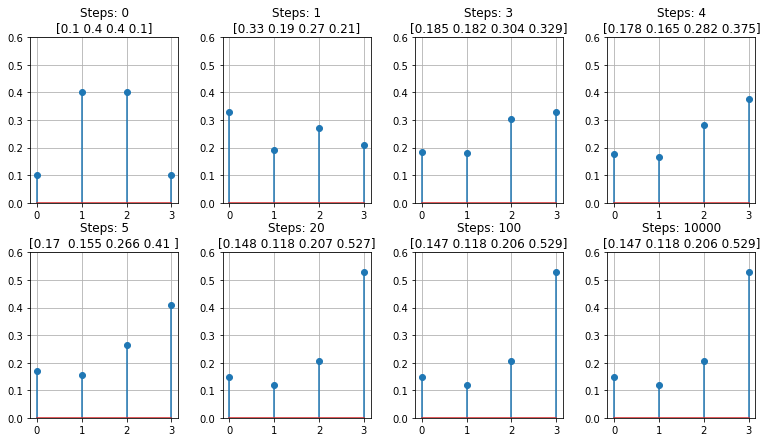

In [4]:
P = np.array([
[0.0, 0.3, 0.7, 0.0],
[0.8, 0.1, 0.0, 0.1],
[0.0, 0.3, 0.5, 0.2],
[0.1, 0.0, 0.0, 0.9]])

pi_T = np.array([0.1, 0.4, 0.4, 0.1])

pis = []
steps = (0, 1, 3, 4, 5, 20, 100, 10000)
for i in steps:
    pis.append(pi_T.dot(np.linalg.matrix_power(P, i)))

plt.figure(figsize=(13, 7))
for i, pi in enumerate(pis):
    plt.subplot(2, 4, i+1)
    plt.title('Steps: {0}\n{1}'.format(steps[i], pi))
    plt.stem(pi)
    plt.ylim(0, 0.6)
plt.show()

Je celkem patrné, že již po několika krocích jsou změny malé. Tato konvergence do stacionárního stavu samozřejmě může trvat různě dlouho dobu, v závislosti na složitosti grafu, resp. modelu. A samozřejmě musí být splněny určité podmínky, o tom více níže. Podívejme se ale na jednu významnou vlastnost spojenou s maticí $P$:

In [5]:
np.linalg.matrix_power(P, 600)

array([[0.147, 0.118, 0.206, 0.529],
       [0.147, 0.118, 0.206, 0.529],
       [0.147, 0.118, 0.206, 0.529],
       [0.147, 0.118, 0.206, 0.529]])

Je patrné, že **řádky matice $P$ konvergují s $t\to\infty$ k hodnotám stacionární distribuce**. Z toho současně plyne, že - za určitých podmínek - stacionární rozdělení markovského řetězce **nezávisí na počátečním rozdělení** (zamyslete se proč, nápověda: počáteční rozdělení je pravděpodobnostní vektor a je tedy normovaný. Odpověď plyne z násobení $\pi^\intercal P$).

Podívejme se nyní na konvergenci $\pi^\intercal$ ke stacionární distribuci pro 100 kroků pro dvě naprosto různé počáteční distribuce.

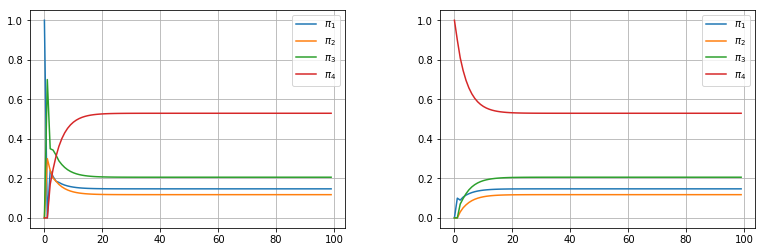

In [6]:
steps = 100
pi1_T = np.array([1, 0, 0, 0])
pi2_T = np.array([0, 0, 0, 1])
pis_1 = np.zeros((steps, pi1_T.size))
pis_2 = np.zeros((steps, pi2_T.size))
for i in range(100):
    pis_1[i] = pi1_T.dot(np.linalg.matrix_power(P, i))
    pis_2[i] = pi2_T.dot(np.linalg.matrix_power(P, i))
    
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(pis_1)
plt.legend([r'$\pi_1$', r'$\pi_2$', r'$\pi_3$', r'$\pi_4$'])
plt.subplot(1, 2, 2)
plt.plot(pis_2)
plt.legend([r'$\pi_1$', r'$\pi_2$', r'$\pi_3$', r'$\pi_4$'])
plt.show()

Příkladem nekonvergujícího řetězce je řetězec s přechodovou maticí

$$
\begin{bmatrix}
0 & 1 \\ 1 & 0
\end{bmatrix}.
$$

Ten vyznačuje pro každé $t=1, 2, \ldots$ jisté přeskoky mezi dvěma stavy, přičemž

$$
\begin{aligned}
P^t=
&\begin{bmatrix}
0 & 1 \\ 1 & 0
\end{bmatrix} 
\qquad\text{je-li $t$ liché},
\\
P^t=
&\begin{bmatrix}
1 & 0 \\ 0 & 1
\end{bmatrix}
\qquad\text{je-li $t$ sudé},
\end{aligned}
$$


### Ireducibilita, aperiodicita

> **Definice**
> 
> Říkáme, že stav $j\in S$ je **dosažitelný** ze stavu $i\in S$, pokud existuje $t$ takové, že $(P^t)_{ij}>0$.

Dosažitelnost zapisujeme $i\to j$. **Sousledným** stavem pak označujeme takový, kdy $i\to j$ a současně $j\to i$. To zapisujeme $i \leftrightarrow j$.

> **Definice**
>
> Říkáme, že stavy $i$ a $j$ jsou ve stejné **třídě ekvivalence**, pokud $i \leftrightarrow j$. 

Tyto třídy se někdy nazývají *komponenty*, anglicky _communicating class_. 

> **Definice**
>
> Třída ekvival. stavů se nazývá **uzavřená**, pokud ji není možné opustit.

![tridy](img/l1-classes.jpg)

> **Definice**
>
> Říkáme, že stav $i\in S$ je **trvalý** (rekurentní), jestliže pravděpodobnost, že se řetězec po jeho opuštění někdy vrátí, je 1. Stav je **přechodný** (persistentní), jestliže není trvalý.

Stav trvalý je tedy ten, do kterého se po jeho opuštění někdy vrátíme s pravděpodobností 1. U přechodného stavu je tato pravděpodobnost menší než 1, je tedy možné se dostat do jiného dosažitelného stavu, ze kterého již není návratu (tedy není stavem sousledným). Speciálním případem je potom stav **absorpční**, který nelze opustit, neboť $(P)_{ii} = 1$.

> **Definice**
>
> Říkáme, že markovský řetězec nebo přechodová matice je **ireducibilní**, pokud pro všechna $i,j\in S$ je $i \leftrightarrow j$.

Ireducibilní řetězec má jako stavový prostor jedinou třídu ekvivalence, je tedy možné se dostat z každého stavu do každého jiného stavu. Existuje tedy takové $t$, pro nějž platí $p_{ij}^t>0$.

Ireducibilita je nutnou podmínkou konvergence do stacionárního rozdělení, neboť zamezuje situaci, kdy při různých počátečních rozděleních dospěje řetězec do různých finálních rozdělení. Stacionarita je podmíněna schopností zapomenout počáteční rozdělení.

> **Definice**
>
> **Periodou** stavu $i\in S$ nazýváme číslo
>
>$$
d(i) = \operatorname{gcd}\{t: (P^t)_{ii} > 0\}.
$$

gcd značí největší společný dělitel (greatest common divisor). Perioda stavu $i$ je tedy časový úsek, po kterém se opakovaně dostáváme zpět. To ovšem neplatí úplně stoprocentně - pokud je návrat do stavu $i$ možný po 6, 8, 10, 12 krocích, je $d(i)=2$, ačkoliv dva kroky nejsou v této množině obsaženy.

> **Definice**
>
> Stav $i$ nazveme **periodickým**, pokud $d(i)>1$.

Stav, který je periodický, má $(P^t)_{ii} = 0$, pokud $t$ není násobkem periody $d(i)$.

> **Definice**
>
> Stav $i$ nazveme **aperiodickým**, pokud $d(i)=1$.

To znamená, že do aperiodického stavu se můžeme dostat v různých časech, tedy ne pouze pravidelně v násobcích periody.

> **Věta**
>
> Jestliže dva stavy $i \leftrightarrow j$, potom mají stejnou periodu.

Tuto větu nebudeme dokazovat, má pro nás ale zásadní dopad: **Jestliže markovský řetězec je ireducibilní a má jeden aperiodický stav, potom jsou i všechny ostatní stavy aperiodické.** Povšimněme si, že mluvíme o řetězci - ireducibilitu a aperiodicitu mu připisujeme, pokud se týká všech jeho stavů.

> **Věta**
>
> Nechť $\{X_0, X_1, \ldots\}$ je ireducibilní a aperiodický markovský řetězec s přechodovou maticí $P$ a nechť existuje stacionární distribuce $\pi^\intercal$. Potom pro libovolný počáteční stav $i\in S$ a libovolný konečný stav $j \in S$ a pro $t\to\infty$ platí
>
>$$
\mathbb{P}(X_t = j|X_0 = i) \to \pi^\intercal.
$$

To jest, pro $t\to\infty$, $(P^t)_{ij} \to \pi_j$ pro všechny dvojice $i,j\in S$. $P^t$ tedy konverguje k matici, v níž jsou všechny řádky identické a rovné $\pi^\intercal$.

Problémy mohou nastat, pokud je stavový prostor nekonečný, neboť potom nemusí stacionární distribuce existovat. A naopak, stacionarita může existovat i v případech, kdy některé z výše uvedených podmínek nejsou zachovány. To už je ale za hranicemi našeho předmětu.

---

---

##### Příklad pod čarou - ireducibilní aperiodický řetězec s nekonečným stavovým prostorem


$$
P =
\begin{bmatrix}
q & p & 0 & 0 & \ldots \\
q & 0 & p & 0 & \ldots \\
0 & q & 0 & p & \ldots \\
\vdots & & & 
\end{bmatrix}
$$

Máme vyšetřit existenci stacionární distribuce $\pi^\intercal$, tj. řešit rovnici $\pi^\intercal P = \pi^\intercal$ kde $\sum_{i=0}^\infty \pi_i = 1$. Tedy

$$
\begin{aligned}
q \pi_0 + q \pi_1 &= \pi_0 \\
p \pi_0 + q \pi_2 &= \pi_1 \\
p \pi_1 + q \pi_3 &= \pi_2 \\
&\vdots \\
p \pi_{k-1} + q \pi_{k+1} &= \pi_k
\end{aligned},
$$

$k=1,2,\ldots$ Úpravami dostáváme 

$$
\begin{aligned}
\pi_1 &= \frac{p}{q}\pi_0 \\
\pi_2 &= \left(\frac{p}{q}\right)\pi_0
\end{aligned}
$$

což vede k domněnce $\pi_k = \left( \frac{p}{q}\right)^k \pi_0$, což ověříme indukcí: $\pi_{k+1} = \left( \frac{p}{q}\right)^{k+1} \pi_0$.

Z předpokladu normovanosti

$$
\sum_{i=0}^\infty \pi_i = 1 \qquad \Rightarrow \qquad \sum_{k=0}^\infty \left(\frac{p}{q}\right)^k = 1.
$$

To je ovšem geometrická řada a konverguje pouze pokud $\left| \frac{p}{q} \right| <1$. Tedy za podmínky $p<q$ máme 

$$
\pi_0 \frac{1}{1-\frac{p}{q}} = 1 \qquad \Rightarrow \qquad \pi_0 = 1 - \frac{p}{q}.
$$

Pokud $p\geq q$, stacionární distribuce neexistuje.

## Další vlastnosti markovských řetězců, aneb co jsme přeskočili

Na problematiku markovských řetězců (nebo dokonce obecně procesů) by mohl být celý předmět, a to nejeden. Ze základních pojmů jsme vynechali zejména:

- transientní chování, ergodicita
- všechny možné časy, např. čas prvního průchodu atd. [hitting time] 
- všechny možné počty, např. počet průchodů stavem
- a samozřejmě všechny možné nehomogenity
- ...a spojitosti :-)